In [1]:
import transformers, datasets
transformers.utils.logging.set_verbosity_error()
datasets.utils.logging.set_verbosity_error()

# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [2]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')
smaller_dataset = load_dataset('amazon_polarity')
smaller_dataset["calib"] = smaller_dataset["train"].filter(lambda e, i: i>=18000 and i<20000, with_indices=True)
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<18000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<2000, with_indices=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

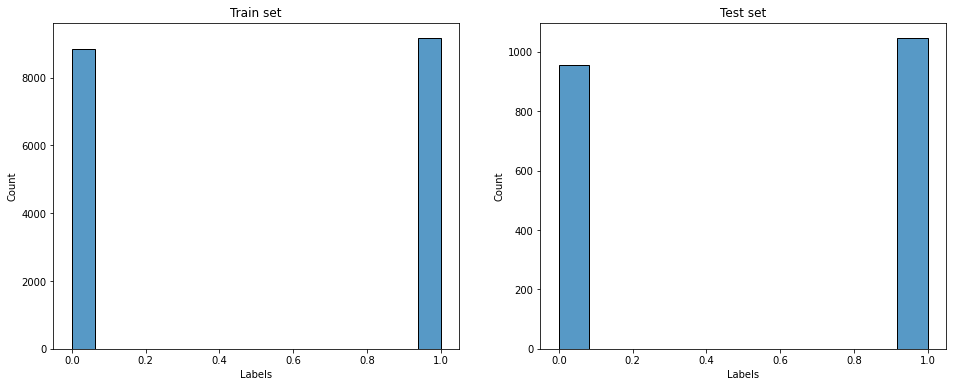

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(smaller_dataset["train"]["label"], ax=ax[0])
sns.histplot(smaller_dataset["test"]["label"], ax=ax[1])
ax[0].set_xlabel('Labels'); ax[1].set_xlabel('Labels');
ax[0].set_title('Train set'); ax[1].set_title('Test set');

### DistilBERT Tokenizer

In [4]:
from transformers import AutoTokenizer

tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function_distilbert(examples):
    return tokenizer_distilbert(examples["title"], truncation=True)

In [5]:
tokenized_dataset_distilbert = dataset['test'].map(preprocess_function_distilbert, batched=True)
smaller_tokenized_dataset_distilbert = smaller_dataset.map(preprocess_function_distilbert, batched=True)

### RoBERTa Tokenizer

In [6]:
from transformers import AutoTokenizer

tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")
def preprocess_function_roberta(examples):
    return tokenizer_roberta(examples["title"], truncation=True)

In [7]:
tokenized_dataset_roberta = dataset['test'].map(preprocess_function_roberta, batched=True)
smaller_tokenized_dataset_roberta = smaller_dataset.map(preprocess_function_roberta, batched=True)

## Model

### CountVectorizer & Logistic Regression

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

vectorizer = CountVectorizer()
#scaler = StandardScaler()
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipe = Pipeline(steps=[("vectorizer", vectorizer), ("logistic", logistic)])

param_grid = {
    "vectorizer__lowercase": [False, True],
    "vectorizer__stop_words": [None, 'english'],
    "vectorizer__ngram_range": [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    "vectorizer__max_features": [None, 100, 300],
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1)
search.fit(smaller_dataset["train"]["title"], smaller_dataset["train"]["label"])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameter (CV score=0.790):
{'logistic__C': 21.54434690031882, 'vectorizer__lowercase': True, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}


In [9]:
predicted_proba_cv_lr = search.best_estimator_.predict_proba(smaller_tokenized_dataset_distilbert["test"]["title"])

In [10]:
from scipy.special import softmax
data_cv_lr = predicted_proba_cv_lr[:,1], np.array(smaller_tokenized_dataset_distilbert["test"]["label"]), softmax(predicted_proba_cv_lr, axis=1)[:,1]

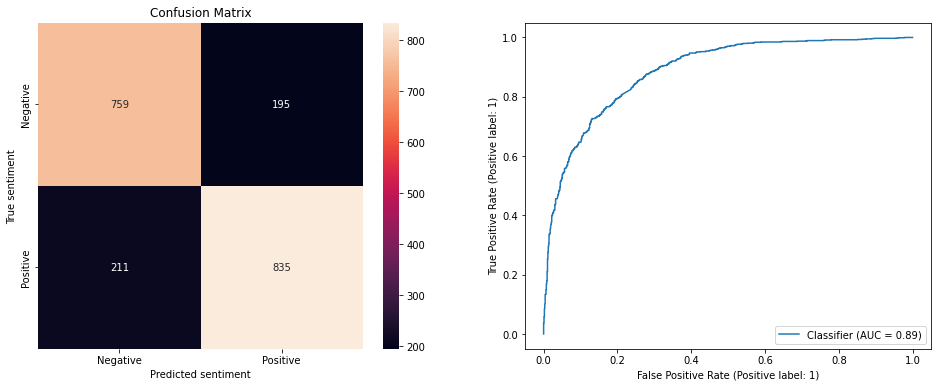

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_cv_lr = (data_cv_lr[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_cv_lr[1], y_hat_cv_lr), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_cv_lr[1], predicted_proba_cv_lr[:,1], ax=ax[1])

### DistilBERT

In [12]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_distilbert = DataCollatorWithPadding(tokenizer=tokenizer_distilbert)
model_distilbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [14]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args_distilbert = TrainingArguments(
    output_dir="./results_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args_distilbert,
    train_dataset=smaller_tokenized_dataset_distilbert["train"],
    eval_dataset=smaller_tokenized_dataset_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    data_collator=data_collator_distilbert
)

trainer_distilbert.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running training *****
  Num examples = 18000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2815


Step,Training Loss
500,0.300200
1000,0.251500
1500,0.184200
2000,0.131000
2500,0.102500


Saving model checkpoint to ./results_distilbert/checkpoint-500
Configuration saved in ./results_distilbert/checkpoint-500/config.json
Model weights saved in ./results_distilbert/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results_distilbert/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results_distilbert/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results_distilbert/checkpoint-1000
Configuration saved in ./results_distilbert/checkpoint-1000/config.json
Model weights saved in ./results_distilbert/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results_distilbert/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results_distilbert/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results_distilbert/checkpoint-1500
Configuration saved in ./results_distilbert/checkpoint-1500/config.json
Model weights saved in ./results_distilbert/checkpoint-1500/pytorch_model.bin
tok

TrainOutput(global_step=2815, training_loss=0.18227113754245358, metrics={'train_runtime': 3564.78, 'train_samples_per_second': 25.247, 'train_steps_per_second': 0.79, 'total_flos': 440255399433216.0, 'train_loss': 0.18227113754245358, 'epoch': 5.0})

In [15]:
trainer_distilbert.save_model('distilbert')

Saving model checkpoint to distilbert
Configuration saved in distilbert/config.json
Model weights saved in distilbert/pytorch_model.bin
tokenizer config file saved in distilbert/tokenizer_config.json
Special tokens file saved in distilbert/special_tokens_map.json


**Load pretrained model**

In [16]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('./distilbert/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_distilbert = DataCollatorWithPadding(tokenizer=tokenizer_distilbert)

training_args_distilbert = TrainingArguments(
    output_dir="./results_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args_distilbert,
    train_dataset=smaller_tokenized_dataset_distilbert["train"],
    eval_dataset=smaller_tokenized_dataset_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    data_collator=data_collator_distilbert
)

loading configuration file ./distilbert/config.json
Model config DistilBertConfig {
  "_name_or_path": "./distilbert/",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file ./distilbert/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at ./distilbert/.
If your task is similar to the task the model of 

In [17]:
import torch
import torch.nn.functional as F
predicted_distilbert = trainer_distilbert.predict(smaller_tokenized_dataset_distilbert["test"])

predicted_proba_distilbert = torch.tensor(predicted_distilbert.predictions)
predicted_softmax_distilbert = F.softmax(predicted_proba_distilbert, dim=1)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


In [18]:
data_distilbert = predicted_proba_distilbert[:,1].numpy(), np.array(smaller_tokenized_dataset_distilbert["test"]["label"]), predicted_softmax_distilbert[:,1].numpy()

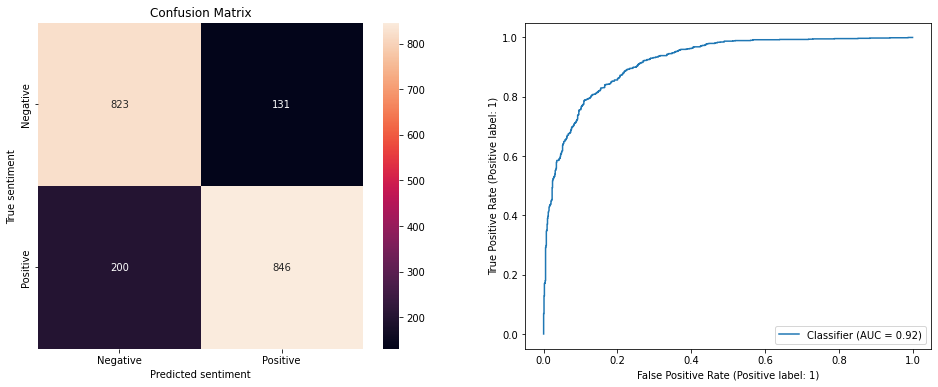

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_distilbert = (data_distilbert[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_distilbert[1], y_hat_distilbert), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_distilbert[1], predicted_proba_distilbert[:,1], ax=ax[1])

## Model

### RoBERTa

In [20]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)
model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /Users/q_user/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/robert

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=smaller_tokenized_dataset_roberta["train"],
    eval_dataset=smaller_tokenized_dataset_roberta["test"],
    tokenizer=tokenizer_roberta,
    data_collator=data_collator_roberta
)

trainer_roberta.train()

In [ ]:
trainer_roberta.save_model('roberta')

**Load pretrained model**

In [22]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('./results_roberta/checkpoint-1000/')

from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=smaller_tokenized_dataset_roberta["train"],
    eval_dataset=smaller_tokenized_dataset_roberta["test"],
    tokenizer=tokenizer_roberta,
    data_collator=data_collator_roberta
)

loading configuration file ./results_roberta/checkpoint-1000/config.json
Model config RobertaConfig {
  "_name_or_path": "./results_roberta/checkpoint-1000/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./results_roberta/checkpoint-1000/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSe

In [23]:
import torch
import torch.nn.functional as F
predicted_roberta = trainer_roberta.predict(smaller_tokenized_dataset_roberta["test"])

predicted_proba_roberta = torch.tensor(predicted_roberta.predictions)
predicted_softmax_roberta = F.softmax(predicted_proba_roberta, dim=1)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


In [24]:
data_roberta = predicted_proba_roberta[:,1].numpy(), np.array(smaller_tokenized_dataset_roberta["test"]["label"]), predicted_softmax_roberta[:,1].numpy()

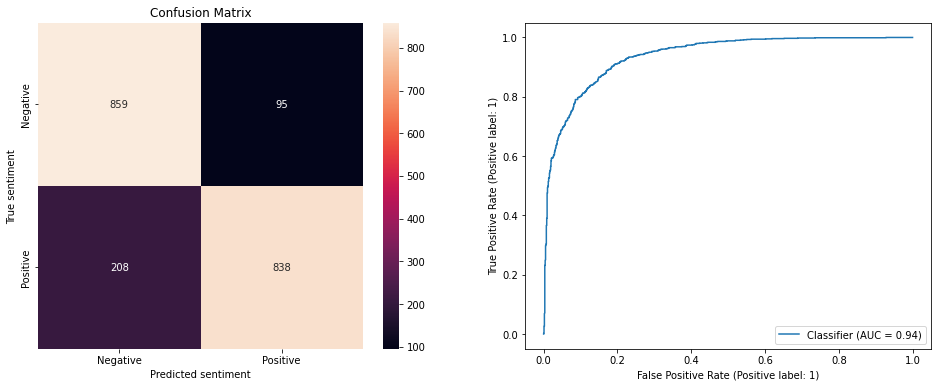

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat_roberta = (data_roberta[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_roberta[1], y_hat_roberta), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted sentiment'); ax[0].set_ylabel('True sentiment')
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Negative', 'Positive']); ax[0].yaxis.set_ticklabels(['Negative', 'Positive'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_roberta[1], predicted_proba_roberta[:,1], ax=ax[1])

## Evaluation - Permutation test

In [29]:
from tqdm import tqdm
import random
def permutation_test(y_hat_1, y_hat_2, y_true, score, n_eval=10000):
    D = abs(score(y_hat_1, y_true) - score(y_hat_2, y_true))
    counter = 0
    for i in tqdm(range(n_eval)):
        change = np.array([random.randint(0, 1) for x in range(len(y_true))])
        same = 1 - change
        
        y_hat_1_eval = same*y_hat_1 + change*y_hat_2
        y_hat_2_eval = same*y_hat_2 + change*y_hat_1
        
        if abs(score(y_hat_1, y_true) - score(y_hat_2, y_true)) > D:
            counter += 1
    return counter / n_eval

In [30]:
from sklearn.metrics import f1_score
permutation_test((data_roberta[0] > 0.5), (data_distilbert[0] > threshold), np.array(smaller_tokenized_dataset_roberta["test"]["label"]), f1_score)

100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 490.39it/s]


0.0

## Evaluation - VennAbers

**Supporting code**

In [31]:
import VennAbers
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil, exp
from sklearn.calibration import CalibratedClassifierCV

def plot_all_score(data):
    rng = np.array(list(range(floor(data[0].min()*100), ceil(data[0].max()*100), 1))) / 100
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), rng)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(rng)
    
    ps = CalibratedClassifierCV()
    ps.fit(data[0].reshape(-1, 1), data[1])
    platt_scaling = ps.predict_proba(rng.reshape(-1, 1))[:,1]
    
    plt.figure(figsize=(10,10))
    #sns.lineplot(x=rng, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(rng, venn_abers[0], venn_abers[1], color='orange', alpha=1)
    #sns.lineplot(x=rng, y=predicted_proba, linestyle='dotted')
    sns.lineplot(x=rng, y=platt_scaling)
    sns.lineplot(data[0], data[2], color='green', alpha=.65)
    plt.axis((floor(data[0].min()), ceil(data[0].max()), 0, 1))
    
    #xpoints = ypoints = plt.xlim()
    #plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(floor(data[0].min()), ceil(data[0].max())+0.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers Interval", "Platt Scaling", "Softmax"])
    plt.xlabel('Score'); plt.ylabel('Calibrated probability')

### DistilBERT

/Users/q_user/miniforge3/envs/nlp_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


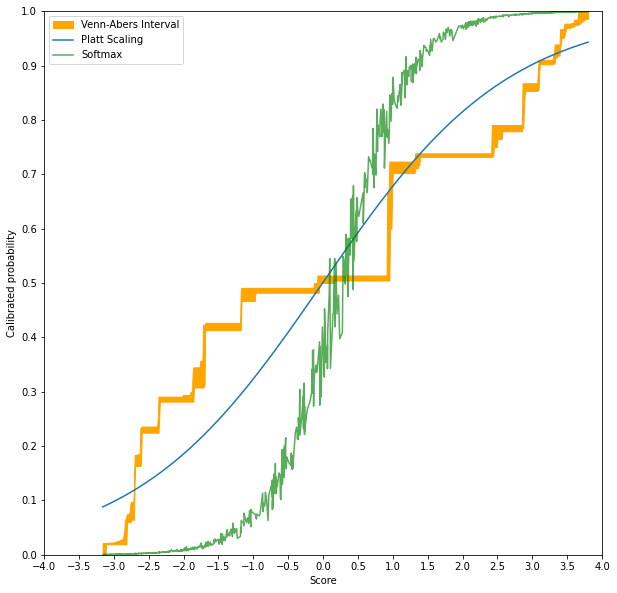

In [32]:
plot_all_score(data_distilbert)

### RoBERTa

/Users/q_user/miniforge3/envs/nlp_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


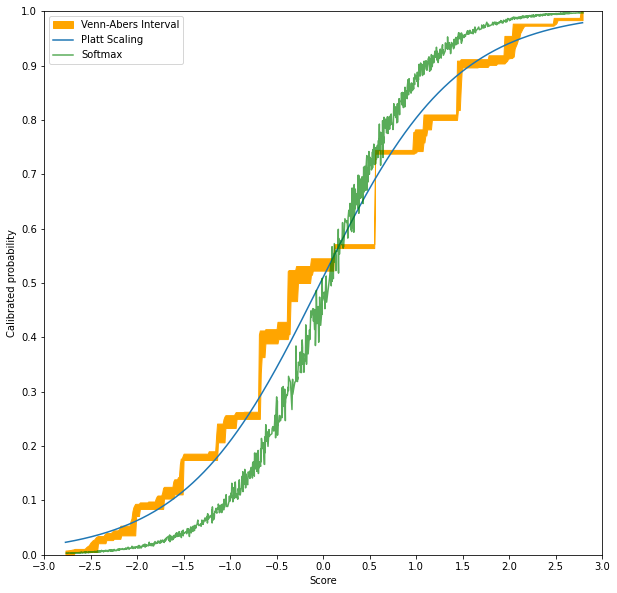

In [33]:
plot_all_score(data_roberta)

## Time evaluation

In [35]:
import time
import VennAbers
from tqdm import tqdm
data_time_eval = data_distilbert

In [38]:
def time_eval_slow(rounds=10):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        for s_x_test in (np.array(list(range(0, 101, 1))) / 100):
            venn_abers = VennAbers.venn_abers(list(zip(data_time_eval[0], data_time_eval[1])), s_x_test)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [39]:
def time_eval_fast(rounds=10):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        venn_abers = VennAbers.venn_abers_fast(list(zip(data_time_eval[0], data_time_eval[1])), np.array(list(range(0, 101, 1))) / 100)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [40]:
time_slow, time_fast = time_eval_slow(), time_eval_fast()
print(f"Slow Venn-Abers (avg. - 100 runs): {round(time_slow)} ms")
print(f"Fast Venn-Abers (avg. - 100 runs): {round(time_fast)} ms")
print(f"Average speed-up of {round((1/time_fast) / (1/time_slow), 1)}x (100 runs)")

Slow Venn-Abers (avg. - 100 runs): 172 ms
Fast Venn-Abers (avg. - 100 runs): 83 ms
Average speed-up of 2.1x (100 runs)


## Evaluation - Conformal

In [43]:
from tqdm import tqdm

def eval_conformal_prediction(model, dataset, test_dataset):
    predicted_calib = model.predict(dataset["calib"])
    y_hat_calib = torch.tensor(predicted_calib.predictions)
    y_calib = np.array(dataset["calib"]["label"])
    
    avg_err = 0
    n = int(len(test_dataset)/2000)
    n = 10
    for i in tqdm(range(n)):
        test_dataset_slice = test_dataset.filter(lambda e, i_f: i_f>=i*2000 and i_f<(i+1)*2000, with_indices=True)
        
        predicted_test = model.predict(test_dataset_slice)
        y_hat_test = torch.tensor(predicted_test.predictions)
        
        prediction_sets = conformal_prediction(y_calib, y_hat_calib, y_hat_test)
        
        avg_err += eval_conformal_prediction_single(prediction_sets, test_dataset_slice['label'])
    return avg_err / n

def eval_conformal_prediction_single(prediction_sets, y):
    for a, b in zip(prediction_sets, y):
        c = 0
        if b in a:
            c += 1
    return 1 - (c / len(prediction_sets))
        

def run_conformal_prediction(model, dataset):
    predicted_calib = model.predict(dataset["calib"])
    y_hat_calib = torch.tensor(predicted_calib.predictions)

    predicted_test = model.predict(dataset["test"])
    y_hat_test = torch.tensor(predicted_test.predictions)

    y_calib = np.array(dataset["calib"]["label"])
    
    return conformal_prediction(y_calib, y_hat_calib, y_hat_test)

def conformal_prediction(y_calib, y_hat_calib, y_hat_test, alpha=0.1):
    sorted, pi = y_hat_calib.softmax(dim=1).sort(dim=1,descending=True)
    scores = sorted.cumsum(dim=1).gather(1, pi.argsort(1))[range(y_calib.shape[0]),y_calib]
    
    qhat = torch.quantile(scores, np.ceil((y_hat_test.shape[0]+1)*(1-alpha))/y_hat_test.shape[0])
    
    test_sorted, test_pi = y_hat_test.softmax(dim=1).sort(dim=1, descending=True)
    sizes = (test_sorted.cumsum(dim=1) > qhat).int().argmax(dim=1)
    prediction_sets = [ test_pi[i][:(sizes[i]+1)] for i in range(sizes.shape[0]) ]
    return prediction_sets

In [44]:
metric = eval_conformal_prediction(trainer_distilbert, smaller_tokenized_dataset_distilbert, tokenized_dataset_distilbert)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
  0%|                                                    | 0/10 [00:00<?, ?it/s]The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 10%|████▍                                       | 1/10 [00:21<03:11, 21.28s/it]The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 20%|████████▊                                   | 2/10 [00:42<02:51, 21.47s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 30%|█████████████▏                              | 3/10 [01:07<02:41, 23.09s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 40%|█████████████████▌                          | 4/10 [01:32<02:21, 23.58s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 50%|██████████████████████                      | 5/10 [01:56<01:58, 23.75s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 60%|██████████████████████████▍                 | 6/10 [02:21<01:36, 24.15s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 70%|██████████████████████████████▊             | 7/10 [02:49<01:16, 25.44s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 80%|███████████████████████████████████▏        | 8/10 [03:16<00:51, 25.96s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
 90%|███████████████████████████████████████▌    | 9/10 [03:40<00:25, 25.50s/it]

  0%|          | 0/400 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
100%|███████████████████████████████████████████| 10/10 [04:04<00:00, 24.46s/it]


In [46]:
metric

0.9996

In [45]:
prediction_sets = run_conformal_prediction(trainer_distilbert, smaller_tokenized_dataset_distilbert)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32
The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, content.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


In [48]:
prediction_sets

[tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([0, 1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0, 1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1, 0]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1, 0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1, 0]),
 tensor([1]),
 tensor([0, 1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1, 0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),